In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import glob

##  Datset path location using glob


In [2]:
building_house=glob.glob('dataset_building/building_house/*.*')
mosque=glob.glob('dataset_building/mosque/*.*')
temple=glob.glob('dataset_building/temple/*.*')
tinshed=glob.glob('dataset_building/tinshed/*.*')
sky_building=glob.glob('dataset_building/sky_building/*.*')
mud_house=glob.glob('dataset_building/mud_house/*.*')

In [3]:
print('Building house data : ',len(building_house))
print('Mosque data: ',len(mosque))
print('Temple data: ',len(temple))
print('Tinshed data: ',len(tinshed))
print('Sky building data: ',len(sky_building))
print('Mud house data: ',len(mud_house))

Building house data :  250
Mosque data:  250
Temple data:  250
Tinshed data:  250
Sky building data:  250
Mud house data:  250


## Dataset Preprocssing using ImageDataGenerator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
WIDTH=224
HEIGHT=224

In [6]:
train_generator = ImageDataGenerator(rescale=1./255,
                                    horizontal_flip=True,
                                    shear_range=0.1 ,
                                    zoom_range=0.1,
                                    #rotation_range=30,
                                    height_shift_range=0.1,
                                    fill_mode='nearest')
                                     
validation_generator=ImageDataGenerator(rescale=1./255)

train_dataset = train_generator.flow_from_directory(batch_size=32,
                                                 directory='dataset_building/train',
                                                 shuffle=True,
                                                 target_size=(WIDTH, HEIGHT),
                                                 class_mode='categorical')

validation_dataset = validation_generator.flow_from_directory(batch_size=32,
                                                 directory='dataset_building/test',
                                                 shuffle=True,
                                                 target_size=(WIDTH, HEIGHT), 
                                                 class_mode='categorical')

Found 1500 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [7]:
train_dataset.class_indices


{'building_house': 0,
 'mosque': 1,
 'mud_house': 2,
 'sky_building': 3,
 'temple': 4,
 'tinshed': 5}

In [8]:
validation_dataset.class_indices


{'building_house': 0,
 'mosque': 1,
 'mud_house': 2,
 'sky_building': 3,
 'temple': 4,
 'tinshed': 5}

In [9]:
total_class=len(train_dataset.class_indices)
print('Number of classes in dataset: ',total_class)

Number of classes in dataset:  6


## Plot some random image
- class 0: building house
- class 1: mosque
- class 2: mud house
- class 3: sky building
- class 4: temple
- class 5: tinshed

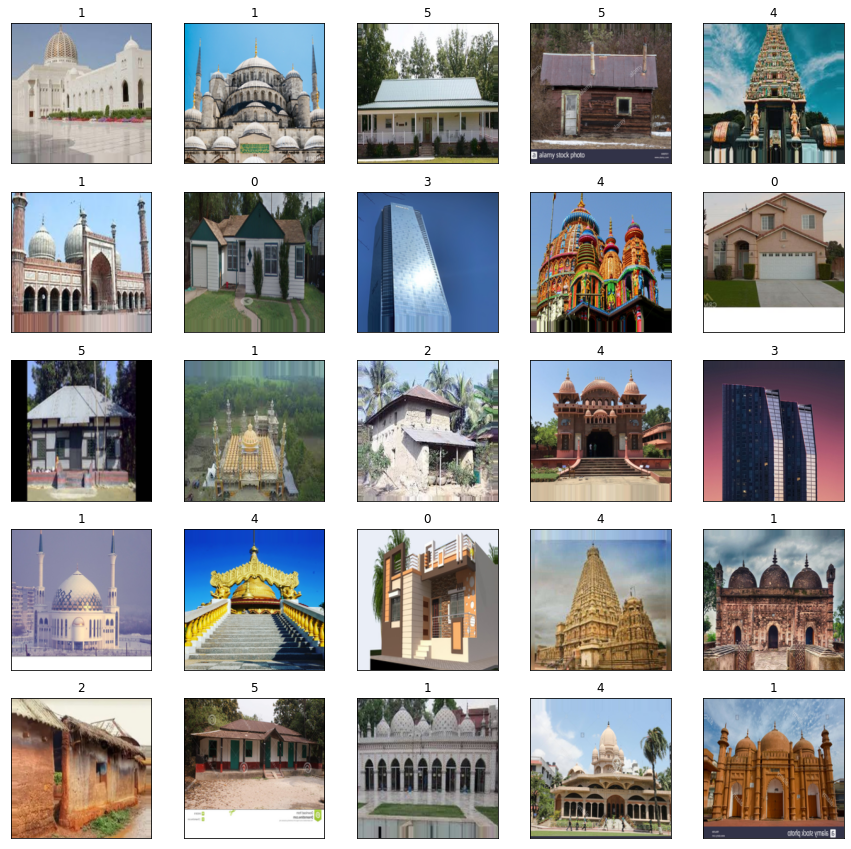

In [10]:
x,y=train_dataset.next()
fig=plt.figure(figsize=(15,15))
rows=5
cols=5
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    image=x[i]
    plt.imshow(image)
    plt.title(np.argmax(y[i]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

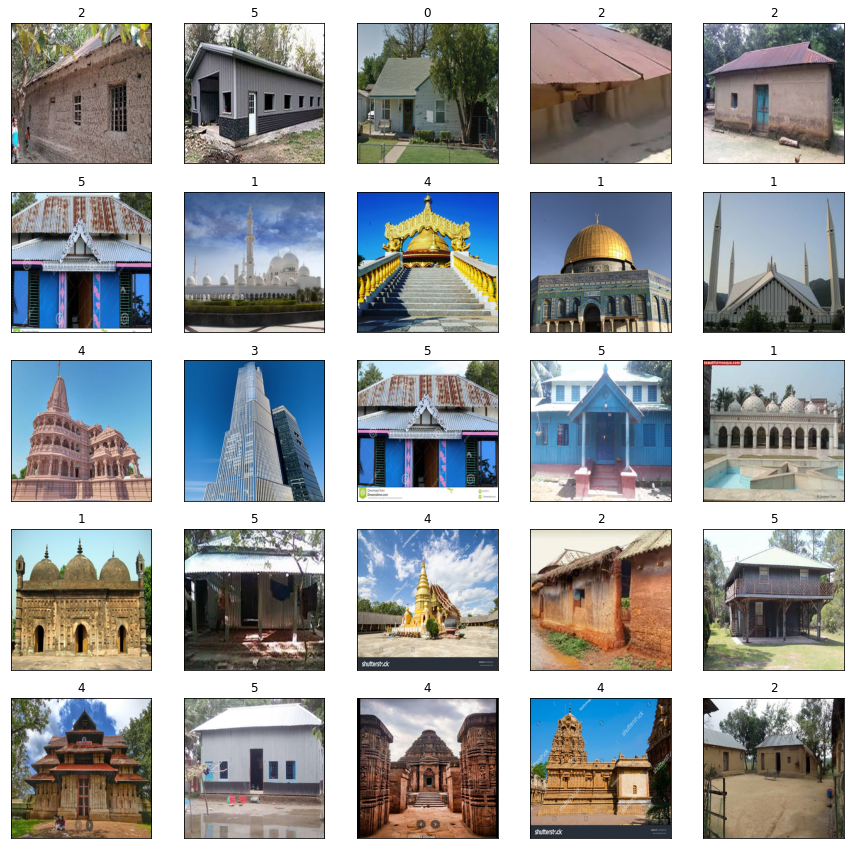

In [11]:
x,y=validation_dataset.next()
fig=plt.figure(figsize=(15,15))
rows=5
cols=5
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    image=x[i]
    plt.imshow(image)
    plt.title(np.argmax(y[i]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()


## Define model architecture


In [12]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.models import Sequential

In [13]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(BatchNormalization())

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.1))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.1))

model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(total_class,activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [15]:
model.layers

## Softmax activation fuction

three class labels will be integer encoded as 0, 1, and 2. Then encoded to vectors as follows:

- Class 0: [1, 0, 0]
- Class 1: [0, 1, 0]
- Class 2: [0, 0, 1]

The softmax output might look as follows, which puts the most weight on class 1 and less weight on the other classes.

[0.09003057 0.66524096 0.24472847] -> [0,1,0]

<b>equaltion</b> e^z/sum (e^z1,...,e^zn)

## Adam optimzer

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

According to Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".

## Compile the model using loss and optimizer

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

## Train the model and save the model suing call backs fucntion

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='building.model.best.hdf5', verbose=1 ,save_best_only=True)

In [18]:
epochs=20
batch_size=32
trainset_length=len(train_dataset.labels)
validation_length=len(validation_dataset.labels)
steps_per_epoch=(trainset_length//batch_size)
validation_steps=(validation_length//batch_size)
print(trainset_length)
print(validation_length)
print(steps_per_epoch)
print(validation_steps)

1500
300
46
9


In [19]:
history = model.fit(train_dataset,
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps)

Epoch 1/20
46/46 [==============================] - 129s 3s/step - loss: 2.0972 - accuracy: 0.2541 - val_loss: 1.6195 - val_accuracy: 0.2500
Epoch 2/20
46/46 [==============================] - 108s 2s/step - loss: 1.4203 - accuracy: 0.4693 - val_loss: 1.2991 - val_accuracy: 0.4792
Epoch 3/20
46/46 [==============================] - 123s 3s/step - loss: 1.2059 - accuracy: 0.5334 - val_loss: 0.8605 - val_accuracy: 0.6771
Epoch 4/20
46/46 [==============================] - 118s 3s/step - loss: 1.0331 - accuracy: 0.6042 - val_loss: 0.7613 - val_accuracy: 0.6910
Epoch 5/20
46/46 [==============================] - 121s 3s/step - loss: 0.9730 - accuracy: 0.6138 - val_loss: 0.6823 - val_accuracy: 0.7292
Epoch 6/20
46/46 [==============================] - 120s 3s/step - loss: 0.8818 - accuracy: 0.6703 - val_loss: 0.6464 - val_accuracy: 0.7743
Epoch 7/20
46/46 [==============================] - 111s 2s/step - loss: 0.7702 - accuracy: 0.7221 - val_loss: 0.5360 - val_accuracy: 0.8021
Epoch 8/20
46

## Testing data using test set

In [22]:
test_loss,test_accuracy=model.evaluate(validation_dataset)

10/10 [==============================] - 3s 321ms/step - loss: 0.0601 - accuracy: 0.9833


## Save Model

In [67]:
import time
t = time.time()

export_path_keras = "Saved Model/CNN_VIS_{}_model_{}.h5".format(test_accuracy,int(t))
print(export_path_keras)
model.save(export_path_keras)

Saved Model/CNN_VIS_0.9833333492279053_model_1619112578.h5


## Testing a random image

In [23]:
from tensorflow.keras.preprocessing import image

(1, 224, 224, 3)
[[0. 1. 0. 0. 0. 0.]]
1


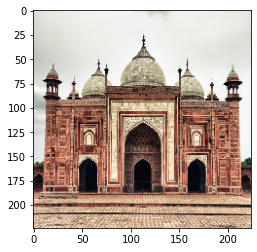

In [24]:
random_image=image.load_img('mosque35.png',target_size=(224,224))
plt.imshow(random_image)
random_image=image.img_to_array(random_image)
test_image=random_image.reshape((1,)+random_image.shape)
print(test_image.shape)
predicted_class=model.predict(test_image)
print(predicted_class)
#print('True classification')
print(np.argmax(predicted_class))

# Layer Visualization 

In [25]:
model_layers = [ layer.name for layer in model.layers]
print('layer name : ',model_layers)

layer name :  ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3', 'max_pooling2d_3', 'dropout', 'flatten', 'dense', 'dropout_1', 'dense_1']


In [26]:
model.layers

In [27]:
from tensorflow.keras.models import Model

In [30]:
conv2d_ouput=Model(inputs=model.input,outputs=model.get_layer('conv2d').output)
conv2d_1_ouput=Model(inputs=model.input,outputs=model.get_layer('conv2d_1').output)
conv2d_2_ouput=Model(inputs=model.input,outputs=model.get_layer('conv2d_2').output)
conv2d_3_ouput=Model(inputs=model.input,outputs=model.get_layer('conv2d_3').output)

In [31]:
conv2d_features=conv2d_ouput.predict(test_image)
conv2d_1_features=conv2d_1_ouput.predict(test_image)
conv2d_2_features=conv2d_2_ouput.predict(test_image)
conv2d_3_features=conv2d_3_ouput.predict(test_image)
print('Conv layer feature output shape: ',conv2d_features.shape)
print('Conv_1 layer feature output shape: ',conv2d_1_features.shape)
print('Conv_2 layer feature output shape: ',conv2d_2_features.shape)
print('Conv_3 layer feature output shape: ',conv2d_3_features.shape)

Conv layer feature output shape:  (1, 224, 224, 32)
Conv_1 layer feature output shape:  (1, 112, 112, 64)
Conv_2 layer feature output shape:  (1, 56, 56, 128)
Conv_3 layer feature output shape:  (1, 28, 28, 256)


([], [])

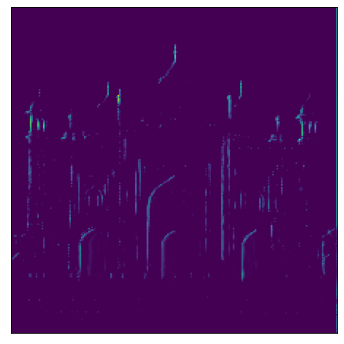

In [32]:
plt.figure(figsize=(6,6))
plt.imshow(conv2d_features[0,:,:,7])
plt.xticks([])
plt.yticks([])

## Convolution layer 1: Visualization

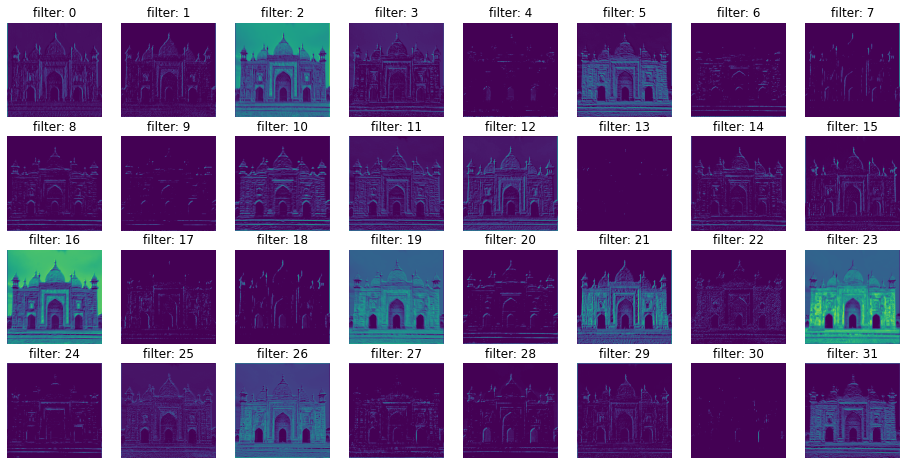

In [33]:
fig = plt.figure(figsize=(16,8))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter: ' + str(i))
    plt.imshow(conv2d_features[0, :, :, i])
plt.show()

## Convolution layer 2: Visualization

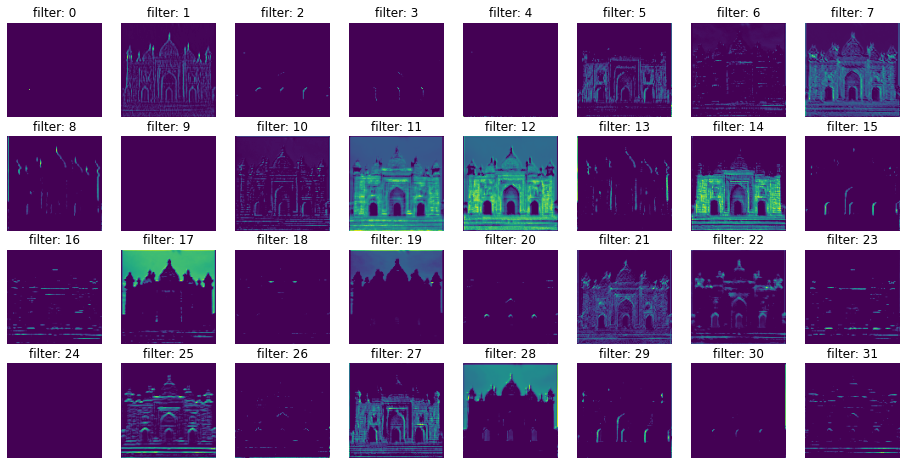

In [34]:
fig = plt.figure(figsize=(16,8))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter: ' + str(i))
    plt.imshow(conv2d_1_features[0, :, :, i])
plt.show()

## Convolution layer 3: Visualization

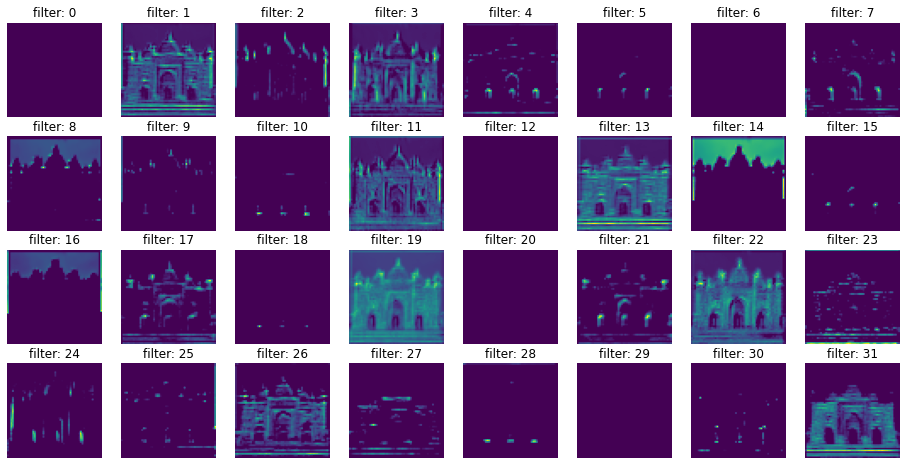

In [35]:
fig = plt.figure(figsize=(16,8))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter: ' + str(i))
    plt.imshow(conv2d_2_features[0, :, :, i])
plt.show()

## Convolution layer 4: Visualization

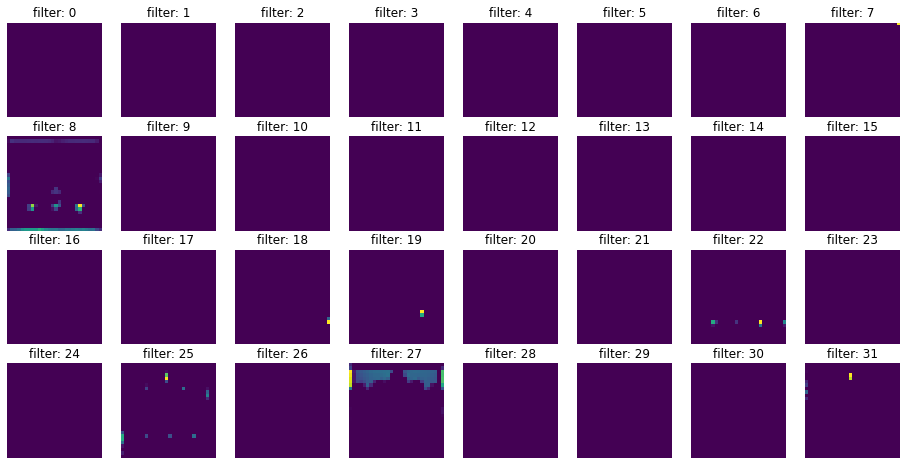

In [47]:
fig = plt.figure(figsize=(16,8))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter: ' + str(i))
    plt.imshow(conv2d_3_features[0, :, :, i])
plt.show()

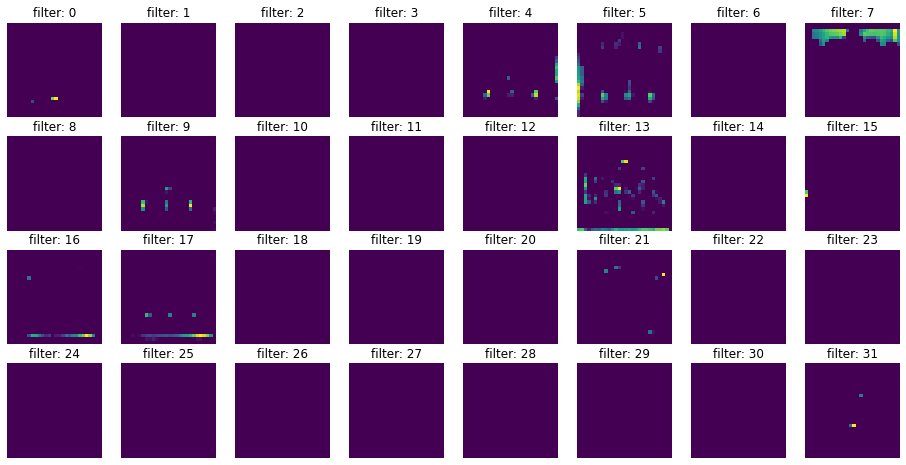

In [50]:
fig = plt.figure(figsize=(16,8))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter: ' + str(i))
    plt.imshow(conv2d_3_features[0, :, :, i+100])
plt.show()

In [55]:
model_layers

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'dropout',
 'flatten',
 'dense',
 'dropout_1',
 'dense_1']

## Maxpooling Layer visualization

In [56]:
max_pooling_2d_output=Model(inputs=model.input,outputs=model.get_layer('max_pooling2d').output)
max_pooling_2d_1_output=Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_1').output)
max_pooling_2d_2_output=Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_2').output)
max_pooling_2d_3_output=Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_3').output)

In [57]:
maxpool2d_features=max_pooling_2d_output.predict(test_image)
maxpool2d_1_features=max_pooling_2d_1_output.predict(test_image)
maxpool2d_2_features=max_pooling_2d_2_output.predict(test_image)
maxpool2d_3_features=max_pooling_2d_3_output.predict(test_image)
print('Conv layer feature output shape: ',maxpool2d_features.shape)
print('Conv_1 layer feature output shape: ',maxpool2d_1_features.shape)
print('Conv_2 layer feature output shape: ',maxpool2d_2_features.shape)
print('Conv_3 layer feature output shape: ',maxpool2d_3_features.shape)

Conv layer feature output shape:  (1, 112, 112, 32)
Conv_1 layer feature output shape:  (1, 56, 56, 64)
Conv_2 layer feature output shape:  (1, 28, 28, 128)
Conv_3 layer feature output shape:  (1, 14, 14, 256)


([], [])

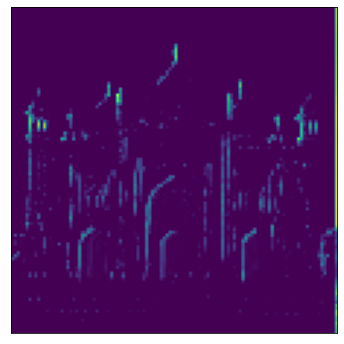

In [58]:
plt.figure(figsize=(6,6))
plt.imshow(maxpool2d_features[0,:,:,7])
plt.xticks([])
plt.yticks([])

## Maxpooling 2D - 1

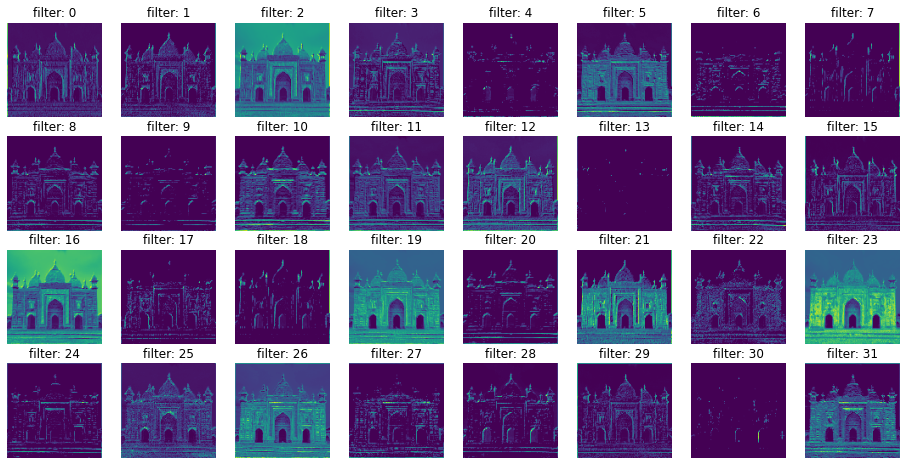

In [59]:
fig = plt.figure(figsize=(16,8))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter: ' + str(i))
    plt.imshow(maxpool2d_features[0, :, :, i])
plt.show()

## Maxpooling 2d- 2

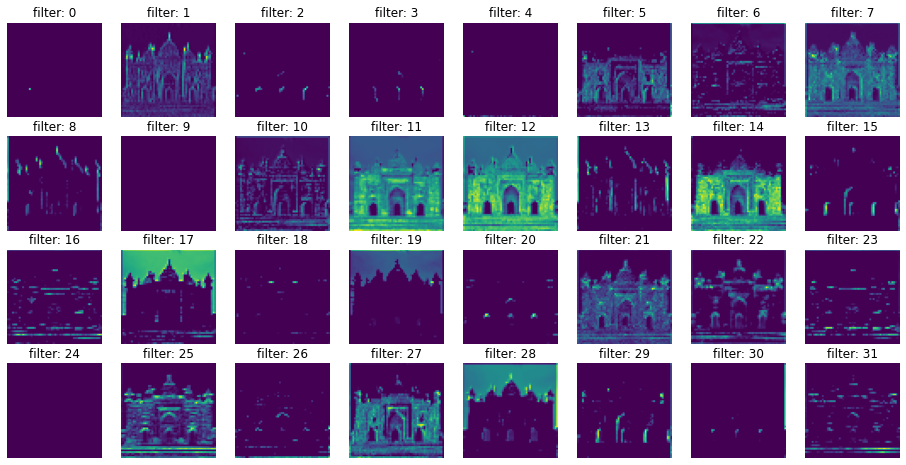

In [62]:
fig = plt.figure(figsize=(16,8))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter: ' + str(i))
    plt.imshow(maxpool2d_1_features[0, :, :, i])
plt.show()

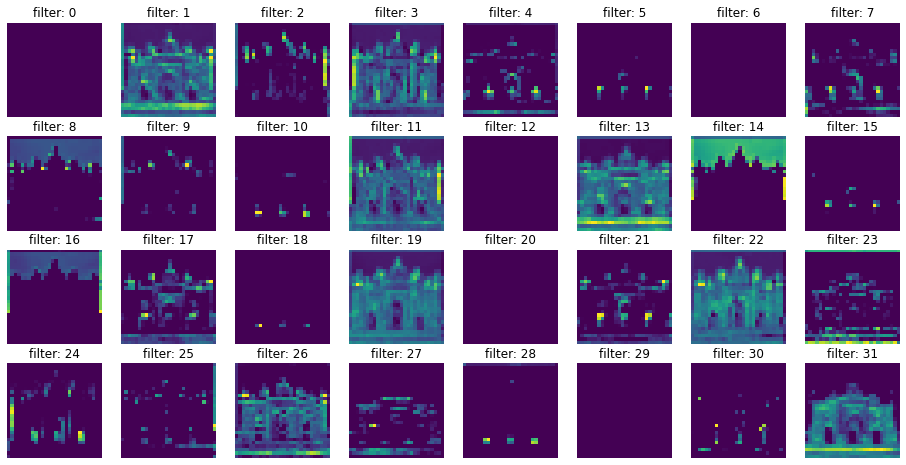

In [63]:
fig = plt.figure(figsize=(16,8))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter: ' + str(i))
    plt.imshow(maxpool2d_2_features[0, :, :, i])
plt.show()

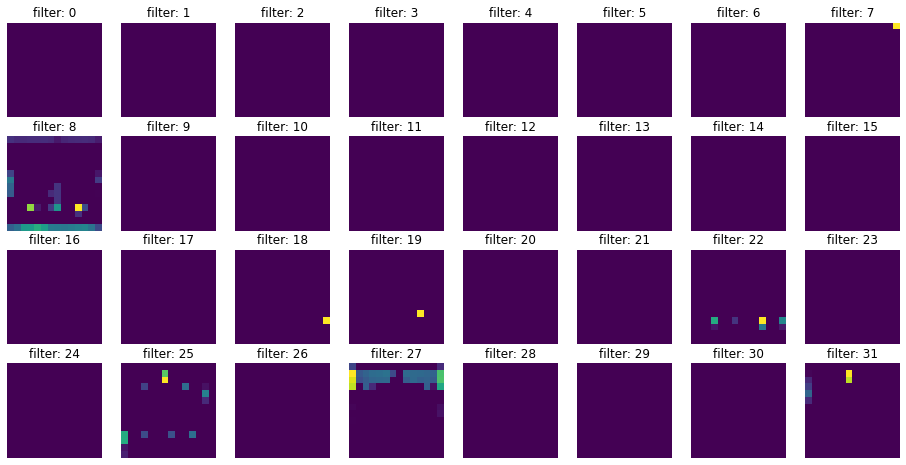

In [65]:
fig = plt.figure(figsize=(16,8))
columns = 8
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter: ' + str(i))
    plt.imshow(maxpool2d_3_features[0, :, :, i])
plt.show()